#INCLUDES

In [ ]:
import re
import nltk
import spacy
import gensim
import operator
import wordcloud
import matplotlib
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
import gensim.downloader as gensim_api
from gensim.models.doc2vec import TaggedDocument

#DOWNLOADS

In [ ]:
!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!python -m spacy download en_core_web_md
import en_core_web_md

nlp = en_core_web_md.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=f19aa52aede54caa5fc00f41e29f96786e0a581095ef6ee387c2a31d8bdb2ebc
  Stored in directory: /tmp/pip-ephem-wheel-cache-_f4k9uaw/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
glove = gensim_api.load('glove-wiki-gigaword-300')

[===========================================-------] 87.3% 328.4/376.1MB downloaded

In [ ]:
# nltk.download('punkt')

In [ ]:
!python -m spacy download en_core_web_lg
import en_core_web_lg

ner = en_core_web_lg.load()

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=842acf55e51d4cbf9f06726e60515d15de516366020496527cbcedea320cd5c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-956ynuwx/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
train = pd.read_csv('train_split.csv')
validation = pd.read_csv('validation_split.csv')
test = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/test.csv')

#DocPreprocess

DocPreprocess:


*   remueve URLs
*   remueve menciones
*   remueve hashtags
*   remueve caracteres especiales
*   agrupa las palabras por tipo (sustantivo-adjetivo-verbo)
*   remueve tildes
*   remueve palabras demasiado cortas (longitud menor o igual a 2)
*   remueve las palabras que no sean de algun tipo contenido en "allowed_postags"
*   aplica lematización


In [ ]:
class DocPreprocess:
  
  def __init__(self,
               nlp,
               stop_words,
               docs,
               allowed_postags = ['ADV', 'VERB', 'ADJ','NOUN', 'PROPN', 'NUM'],
               lem = True):
    
    self.nlp = nlp  # spacy nlp object
    self.stop_words = stop_words  
    self.docs = docs  # docs must be either list or numpy array or series of docs
    self.new_docs = []
    self.new_docs = [self.remove_URL(doc) for doc in self.docs]
    self.new_docs = [self.remove_mention(doc) for doc in self.new_docs]
    self.new_docs = [self.remove_hashtags(doc) for doc in self.new_docs]
    self.new_docs = [self.remove_special_characters(doc) for doc in self.new_docs]
    self.nouns = [self.get_only_words(doc,['NOUN','PROPN']) for doc in self.new_docs]
    self.adjetives = [self.get_only_words(doc,['ADJ']) for doc in self.new_docs]
    self.verbs = [self.get_only_words(doc,['VERB','AUX']) for doc in self.new_docs]
    self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc,min_len = 3 ,max_len = 15, deacc=True) for doc in self.new_docs]
    self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
    if (lem): self.new_docs = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]

  def get_only_words(self,doc,word_types):
    text = nlp(doc)
    wanted_words = []
    for token in text:
      if (token.pos_ in word_types): wanted_words.append(token.lemma_)
    return wanted_words

  def make_simple_doc(self, simple_doc_tokens):
    simple_docs = []
    for doc_tokens in simple_doc_tokens:
      simple = " ".join(doc_tokens)  # concatenate back to a sentence
      simple_docs.append(simple)
    return simple_docs

  def remove_hashtags(self,doc):
    split_doc = doc.split(' ')
    for w in split_doc:
      if ('#' in w): split_doc.remove(w)
    return ' '.join(split_doc)
	
  def remove_special_characters(self,doc):
    return doc.replace('\n', ' ').replace('å', ' ').replace('ê', ' ').replace('û', ' ').replace('[^\w\s]',' ').replace('÷', ' ').replace('ª', ' ').replace('ì', ' ').replace('¢', ' ').replace('\x89', ' ').replace('\x9d', ' ').replace('ã', ' ').replace('ï', ' ').replace('©', ' ').replace('ó', ' ').replace('ò', ' ').replace('â', ' ').replace('\x9b', ' ').replace('\x8a', ' ').replace('\x93', ' ').replace('\x8f', ' ')\
             .replace('\x8c', ' ').replace('¼', ' ').replace('¥', ' ').replace('\x92', ' ').replace('·', ' ').replace('\x82', ' ').replace('Û', ' ').replace('Ó', ' ').replace('Ê', ' ').replace('Ï', ' ')

  def remove_URL(self,doc):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(doc))
	
  def remove_mention(self,doc):
    without_mention = []
    for w in doc.split(' '):
      if ('@' not in w):
        without_mention.append(w)
    return ' '.join(without_mention)

  def lemmatize(self, doc, allowed_postags):
    doc = self.nlp(str(doc))
    tokens = [token.lemma_ for token in doc if (
        token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
    return ' '.join(tokens)


In [ ]:
train_text_preprocess = DocPreprocess(nlp,stop_words,train.text)
validation_text_preprocess = DocPreprocess(nlp,stop_words,validation.text)
test_text_preprocess = DocPreprocess(nlp,stop_words,test.text)

train['clean_text'] = train_text_preprocess.new_docs
validation['clean_text'] = validation_text_preprocess.new_docs
test['clean_text'] = test_text_preprocess.new_docs

train['nouns'] = train_text_preprocess.nouns
validation['nouns'] = validation_text_preprocess.nouns
test['nouns'] = test_text_preprocess.nouns

train['adjetives'] = train_text_preprocess.adjetives
validation['adjetives'] = validation_text_preprocess.adjetives
test['adjetives'] = test_text_preprocess.adjetives

train['verbs'] = train_text_preprocess.verbs
validation['verbs'] = validation_text_preprocess.verbs
test['verbs'] = test_text_preprocess.verbs

In [ ]:
train['clean_keyword'] = train.keyword.apply(lambda x: ' '.join(gensim.utils.simple_preprocess(str(x),min_len = 0 ,max_len = 15, deacc=True)))
validation['clean_keyword'] = validation.keyword.apply(lambda x: ' '.join(gensim.utils.simple_preprocess(str(x),min_len = 0 ,max_len = 15, deacc=True)))
test['clean_keyword'] = test.keyword.apply(lambda x: ' '.join(gensim.utils.simple_preprocess(str(x),min_len = 0 ,max_len = 15, deacc=True)))

#Misspelling

* Creo un features a partir de la cantidad de palabras escritas incorrectamente en ingles (desconocidas).

* Luego utilizando la distancia de Levenshtein creo un feature que busca representar cuan mal estan escritas las palabras

* Por ultimo intento corregir el campo text con el objetivo de que cada palabra se encuentre en el vocabulario de GloVe

In [ ]:
def misspelled_word(corrector,doc):
  words = doc.split(' ')
  return (len(list(corrector.unknown(words))))

def correct_text(corrector,text):
  words = []
  for word in text.split(' '):
    words.append(corrector.correction(word))
  return ' '.join(words)

def count_misspelling(corrector,doc):
  words = corrector.unknown(doc.split(' '))
  distance = 0
  for word in words:
    distance_aux = distance_levenshtein(word,corrector.correction(word))
    #Si pasa esto es porque no reconoce la palabra y no puede corregirla 
    if (distance_aux == 0): distance = distance + len(word)
    else: distance = distance + distance_aux
  return distance

def distance_levenshtein(str1, str2):
  d=dict()
  for i in range(len(str1)+1):
     d[i]=dict()
     d[i][0]=i
  for i in range(len(str2)+1):
     d[0][i] = i
  for i in range(1, len(str1)+1):
     for j in range(1, len(str2)+1):
        d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
  return d[len(str1)][len(str2)]

In [ ]:
train['misspelling_count'] = train['clean_text'].apply(lambda x: count_misspelling(spell,x))
validation['misspelling_count'] = validation['clean_text'].apply(lambda x: count_misspelling(spell,x))
test['misspelling_count'] = test['clean_text'].apply(lambda x: count_misspelling(spell,x))

train['misspelled_word'] = train['clean_text'].apply(lambda x: misspelled_word(spell,x))
validation['misspelled_word'] = validation['clean_text'].apply(lambda x: misspelled_word(spell,x))
test['misspelled_word'] = test['clean_text'].apply(lambda x: misspelled_word(spell,x))

Intento corregir las palabras mal escritas

In [ ]:
train['clean_text'] = train.clean_text.apply(lambda x: correct_text(spell,x))
validation['clean_text'] = validation.clean_text.apply(lambda x: correct_text(spell,x))
test['clean_text'] = test.clean_text.apply(lambda x: correct_text(spell,x))

#Length Analysis

**word count**: número de palabras en el campo text (separadas por espacio)

**character count**: cantidad de caracteres (sin contar espacios)

**sentence count**: cantidad de oraciones (separadas por punto)

**average word length**: cantidad de caracteres divido cantidad de palabras

**average sentence length**: cantidad de palabras sobre cantidad de oraciones

In [ ]:
def word_count(doc):
  return (len(doc.split(' ')))

def character_count(doc):
  return (len(doc.replace(' ','')))

def sentence_count(doc):
  return (len(doc.split('.')))

In [ ]:
train['word_count'] = train.text.apply(lambda x: word_count(x) if x.strip() != '' else 0)
validation['word_count'] = validation.text.apply(lambda x: word_count(x) if x.strip() != '' else 0)
test['word_count'] = test.text.apply(lambda x: word_count(x) if x.strip() != '' else 0)

train['clean_word_count'] = train.clean_text.apply(lambda x: word_count(x) if x.strip() != '' else 0)
validation['clean_word_count'] = validation.clean_text.apply(lambda x: word_count(x) if x.strip() != '' else 0)
test['clean_word_count'] = test.clean_text.apply(lambda x: word_count(x) if x.strip() != '' else 0)

In [ ]:
train['char_count'] = train.text.apply(lambda x: character_count(x) if x.strip() != '' else 0)
validation['char_count'] = validation.text.apply(lambda x: character_count(x) if x.strip() != '' else 0)
test['char_count'] = test.text.apply(lambda x: character_count(x) if x.strip() != '' else 0)

train['clean_char_count'] = train.clean_text.apply(lambda x: character_count(x) if x.strip() != '' else 0)
validation['clean_char_count'] = validation.clean_text.apply(lambda x: character_count(x) if x.strip() != '' else 0)
test['clean_char_count'] = test.clean_text.apply(lambda x: character_count(x) if x.strip() != '' else 0)

In [ ]:
train['sentence_count'] = train.text.apply(lambda x: sentence_count(x) if x.strip() != '' else 0)
validation['sentence_count'] = validation.text.apply(lambda x: sentence_count(x) if x.strip() != '' else 0)
test['sentence_count'] = test.text.apply(lambda x: sentence_count(x) if x.strip() != '' else 0)

In [ ]:
train['avg_word_length'] = train['char_count'] / train['word_count']
validation['avg_word_length'] = validation['char_count'] / validation['word_count']
test['avg_word_length'] = test['char_count'] / test['word_count']

train['avg_clean_word_length'] = train.apply(lambda x: ((x['clean_char_count'])/(x['clean_word_count']) if x['clean_word_count'] != 0 else 0), axis = 1)
validation['avg_clean_word_length'] = validation.apply(lambda x: ((x['clean_char_count'])/(x['clean_word_count']) if x['clean_word_count'] != 0 else 0), axis = 1)
test['avg_clean_word_length'] = test.apply(lambda x: ((x['clean_char_count'])/(x['clean_word_count']) if x['clean_word_count'] != 0 else 0), axis = 1)

train['avg_sentence_lenght'] = train['word_count'] / train['sentence_count']
validation['avg_sentence_lenght'] = validation['word_count'] / validation['sentence_count']
test['avg_sentence_lenght'] = test['word_count'] / test['sentence_count']

In [ ]:
train.sample(5)

,id,keyword,location,text,target,clean_text,nouns,adjetives,verbs,clean_keyword,misspelling_count,misspelled_word,word_count,clean_word_count,char_count,clean_char_count,sentence_count,avg_word_length,avg_clean_word_length,avg_sentence_lenght
1186,2134,catastrophe,NaN,#spark #song Ultimate #preparedness library: h...,0,song ultimate library prepare catastrophe,"[song, Ultimate, library, Catastrophe]",[],[prepare],catastrophe,0,0,13,5,121,37,4,9.307692,7.400000,3.25
634,1164,blight,Scotland,LIKE I SWEAR THE SECRET WE'LL UNCOVER IS THE O...,0,swear secret uncover old god slumber think s g...,"[SECRET, WE'LL, gods, slumber, THERES, blight]",[old],"[swear, UNCOVER, be, think, gonna, be]",blight,0,0,21,10,86,45,2,4.095238,4.500000,10.50
3856,6844,loud%20bang,Kenya,matako_milk: Breaking news! Unconfirmed! I jus...,0,matako_milk breaking news unconfirmed hear lou...,"[matako_milk, news, bang, blast, wind, neighbo...","[unconfirmed, loud]","[break, hear, appear, be]",loud bang,12,2,24,13,113,79,3,4.708333,6.076923,8.00
1502,2694,crush,Everywhere,tiffanyfrizzell has a crush: http://t.co/RaF73...,0,tiffanyfrizzell crush,"[tiffanyfrizzell, crush]",[],[have],crush,15,1,5,2,47,20,2,9.400000,10.000000,2.50
2008,3603,desolation,"Houston, Texas !",Photoset: littlebitofbass: silinski: Ed Sheera...,0,photos littlebitofbass silinski sheehan hobbit...,"[Photoset, littlebitofbass, silinski, Ed, Shee...",[german],[],desolation,27,5,14,9,118,70,5,8.428571,7.777778,2.80


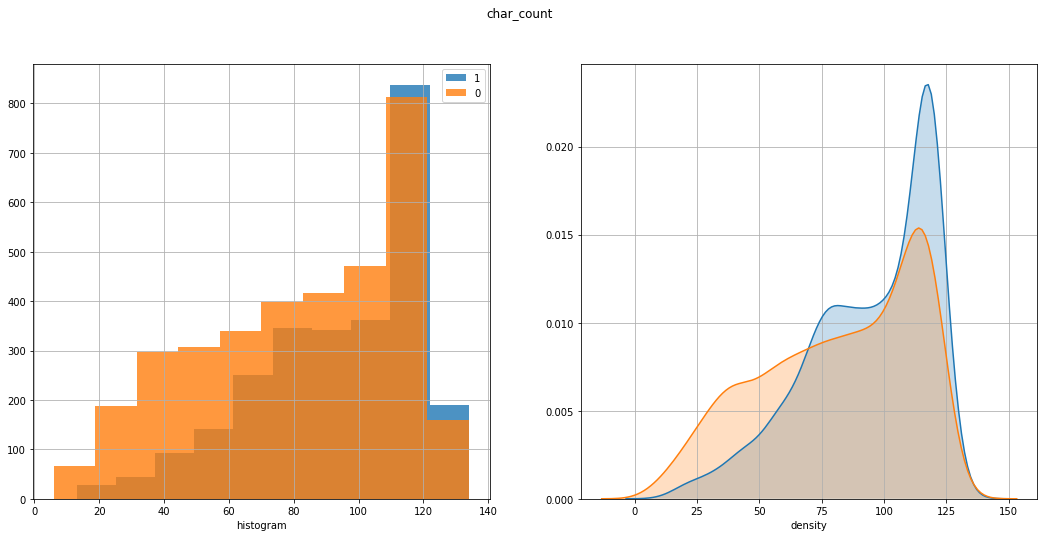

In [ ]:
x = 'char_count'
y = 'target'

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (18,8))
fig.suptitle(x, fontsize=12)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

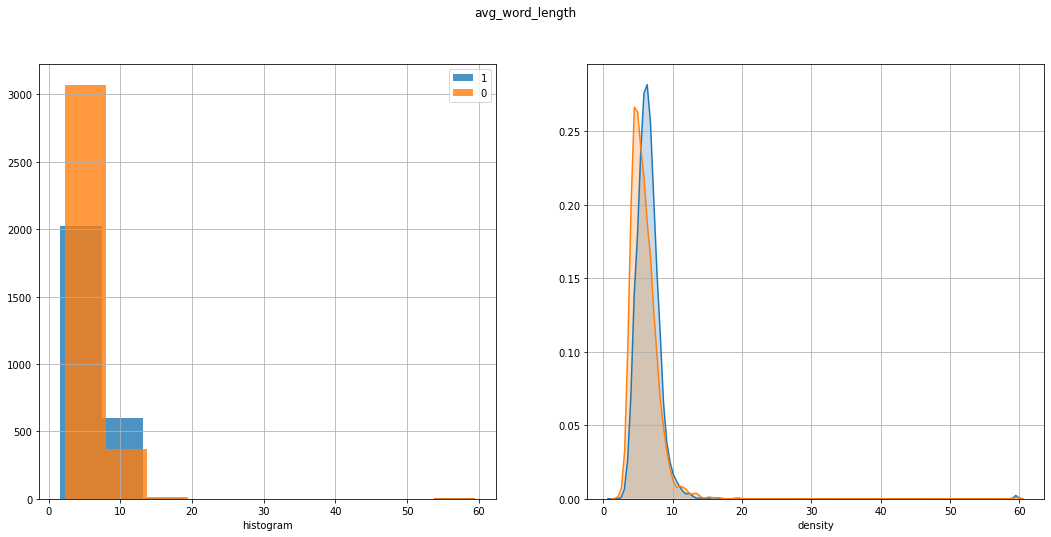

In [ ]:
x = 'avg_word_length'
y = 'target'

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (18,8))
fig.suptitle(x, fontsize=12)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

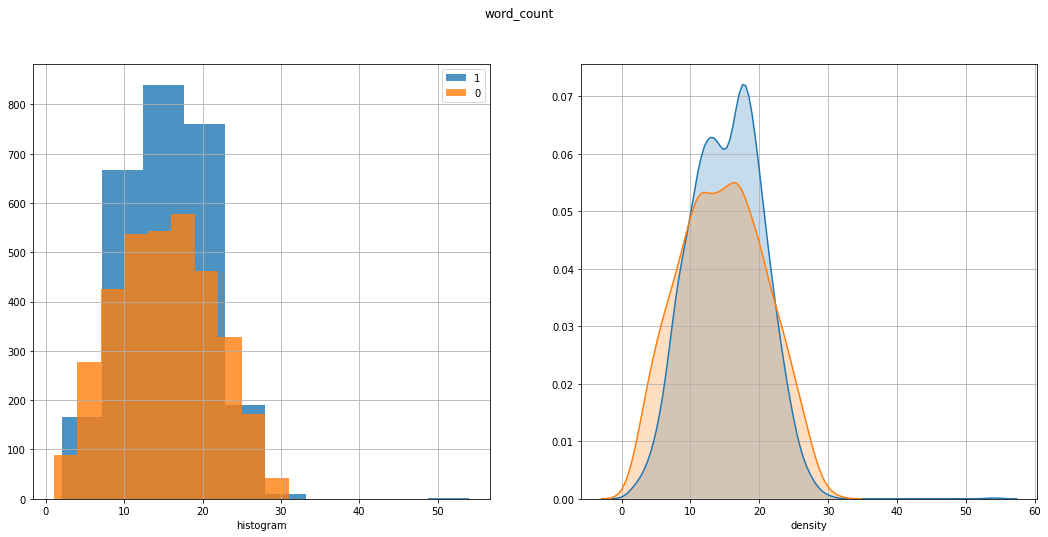

In [ ]:
x = 'word_count'
y = 'target'

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (18,8))
fig.suptitle(x, fontsize=12)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

#Sentiment Analysis

-1 < sentiment.polarity < 1, tal que :

Positive: sentiment.polarity > 0

Neutral: sentiment.polarity = 0

Negative: sentiment.polarity < 0



In [ ]:
train['sentiment'] = train.text.apply(lambda x: TextBlob(x).sentiment.polarity)
validation['sentiment'] = validation.text.apply(lambda x: TextBlob(x).sentiment.polarity)
test['sentiment'] = test.text.apply(lambda x: TextBlob(x).sentiment.polarity)

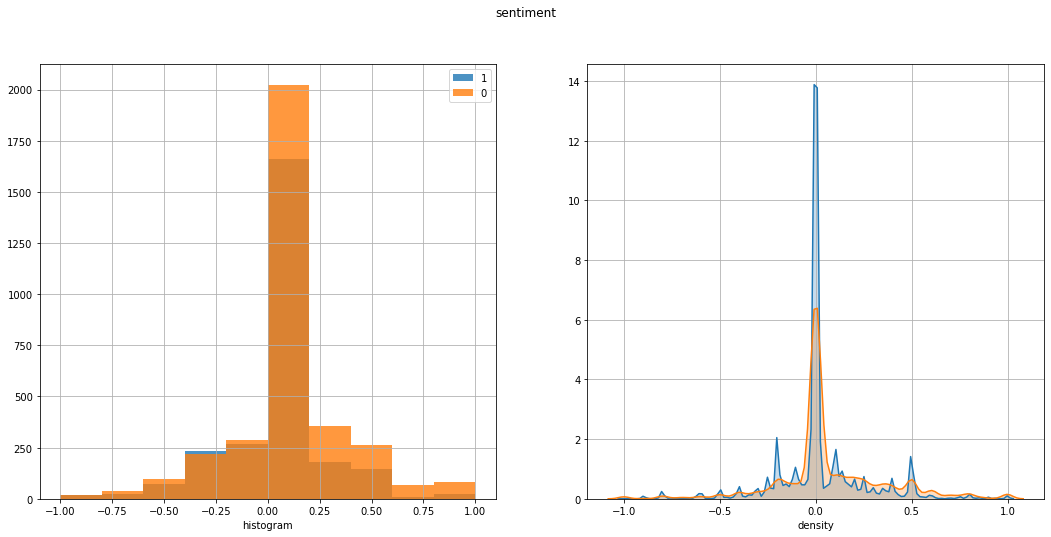

In [ ]:
x = 'sentiment'
y = 'target'

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (18,8))
fig.suptitle(x, fontsize=12)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

#La mayoria de los tweets presentan "neutral sentiments"

# Named-Entity Recognition (NER)

**SpaCy model en_core_web_lg** (the large model for English trained on web data) 

Busco términos particulares que representan entidades específicas que son más informativas y tienen un contexto único. Estas se refieren más específicamente a términos que representan objetos del mundo real como personas, lugares, organizaciones, etc, que a menudo se denotan con nombres propios.

Una vez encontrados, cuento la cantidad de entidades de cada tipo, encontradas en cada tweet

In [ ]:
TAGS = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT','WORK_OF_ART','LAW','LANGUAGE','DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']

for tag in TAGS:
  train[tag] = 0
  validation[tag] =0
  test[tag] = 0

In [ ]:
train['tags'] = train.clean_text.apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents])
validation['tags'] = validation.clean_text.apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents])
test['tags'] = test.clean_text.apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents])

In [ ]:
# utils function to count the element of a list
import collections
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count


In [ ]:
#count tags
train['tags'] = train['tags'].apply(lambda x: utils_lst_count(x))
validation['tags'] = validation['tags'].apply(lambda x: utils_lst_count(x))
test['tags'] = test['tags'].apply(lambda x: utils_lst_count(x))

In [ ]:
# utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if (len(lst_dics_tuples) > 0):
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

# extract features - train
tags_set_train = []
for lst in train['tags'].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set_train.append(k[1])
tags_set_train = list(set(tags_set_train))
for feature in tags_set_train:
     train[feature] = train['tags'].apply(lambda x: utils_ner_features(x, feature))

# extract features - validation
tags_set_validation = []
for lst in validation['tags'].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set_validation.append(k[1])
tags_set_validation = list(set(tags_set_validation))
for feature in tags_set_validation:
     validation[feature] = validation['tags'].apply(lambda x: utils_ner_features(x, feature))

# extract features - test
tags_set_test = []
for lst in test['tags'].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set_test.append(k[1])
tags_set_test = list(set(tags_set_test))
for feature in tags_set_test:
     test[feature] = test['tags'].apply(lambda x: utils_ner_features(x, feature))

#Word Frequency

Busco extraer los unigramas y bigramas unicos mas representativos para cada clase de tweet (0/1)


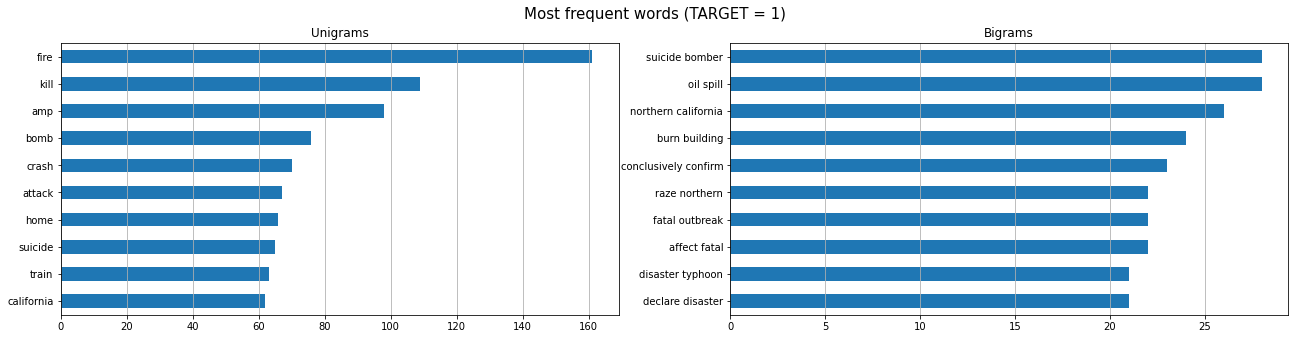

In [ ]:
y = 'target' 

corpus_target1 = train[train[y] == 1]['clean_text']
lst_tokens = nltk.tokenize.word_tokenize (corpus_target1.str.cat (sep = '')) 
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (22,5)) 
fig.suptitle('Most frequent words (TARGET = 1)', fontsize = 15) 
    
## unigrams
dic_words_freq_target1 = nltk.FreqDist (lst_tokens) 
dtf_uni_target1 = pd.DataFrame(dic_words_freq_target1.most_common (), columns = ['Word', 'Freq']) 
dtf_uni_target1.set_index('Word').iloc [:10 ,: ].sort_values('Freq').plot(kind = 'barh', title = 'Unigrams', ax = ax [0], legend = False)
ax[0].grid (axis = 'x') 
ax[0].set(ylabel = None) 
    
## bigrams
dic_words_freq_target1 = nltk.FreqDist (nltk.ngrams (lst_tokens, 2)) 
dtf_bi_target1 = pd.DataFrame (dic_words_freq_target1.most_common (),columns = ['Word', 'Freq']) 
dtf_bi_target1 ['Word'] = dtf_bi_target1['Word'].apply(lambda x: ' '.join (string for string in x)) 
dtf_bi_target1.set_index('Word').iloc [:10,:].sort_values('Freq').plot(kind = 'barh', title = 'Bigrams', ax = ax[1], legend = False) 
ax[1].set(ylabel = None)
ax[1].grid(axis = 'x')
plt.show ()

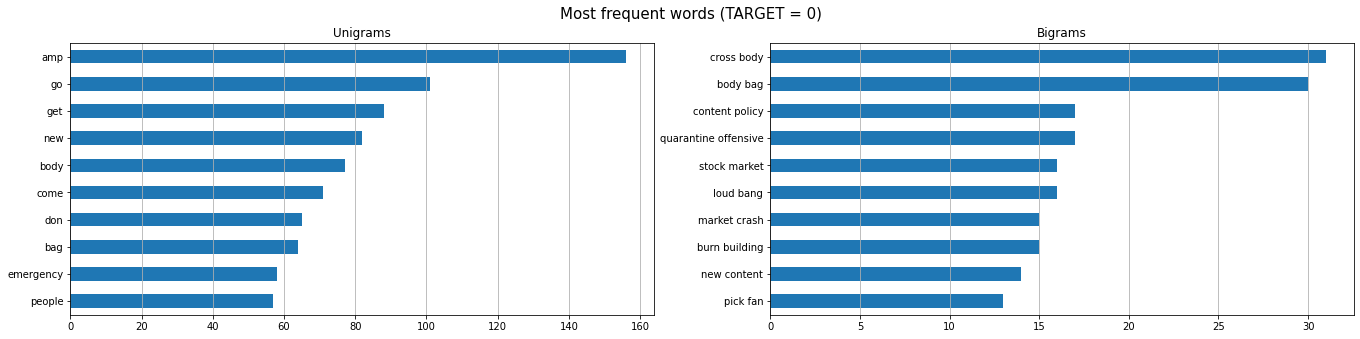

In [ ]:
y = 'target' 

corpus_target0 = train[train[y] == 0]['clean_text']
lst_tokens = nltk.tokenize.word_tokenize (corpus_target0.str.cat (sep = '')) 
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (23,5)) 
fig.suptitle('Most frequent words (TARGET = 0)', fontsize = 15) 
    
## unigrams
dic_words_freq_target0 = nltk.FreqDist (lst_tokens) 
dtf_uni_target0 = pd.DataFrame(dic_words_freq_target0.most_common (), columns = ['Word', 'Freq']) 
dtf_uni_target0.set_index('Word').iloc [:10 ,: ].sort_values('Freq').plot(kind = 'barh', title = 'Unigrams', ax = ax [0], legend = False)
ax[0].grid (axis = 'x') 
ax[0].set(ylabel = None) 
    
## bigrams
dic_words_freq_target0 = nltk.FreqDist (nltk.ngrams (lst_tokens, 2)) 
dtf_bi_target0 = pd.DataFrame (dic_words_freq_target0.most_common (),columns = ['Word', 'Freq']) 
dtf_bi_target0 ['Word'] = dtf_bi_target0['Word'].apply(lambda x: ' '.join (string for string in x)) 
dtf_bi_target0.set_index('Word').iloc [:10,:].sort_values('Freq').plot(kind = 'barh', title = 'Bigrams', ax = ax[1], legend = False) 
ax[1].set(ylabel = None)
ax[1].grid(axis = 'x')
plt.show ()

Unique bigrams

In [ ]:
uniq_bigram_target1 =  set(dtf_bi_target1.Word)
uniq_bigram_target0 =  set(dtf_bi_target0.Word)

aux = uniq_bigram_target1

uniq_bigram_target1 = uniq_bigram_target1 - uniq_bigram_target0
uniq_bigram_target0 = uniq_bigram_target0 - aux

Unique unigrams

In [ ]:
uniq_uni_target1 =  set(dtf_uni_target1.Word)
uniq_uni_target0 =  set(dtf_uni_target0.Word)

aux = uniq_uni_target1

uniq_uni_target1 = uniq_uni_target1 - uniq_uni_target0
uniq_uni_target0 = uniq_uni_target0 - aux

In [ ]:
def contain_n_gram(doc,n_grams):
  count = 0
  for n_gram in n_grams:
    count = count + doc.count(n_gram)
  return count

In [ ]:
train['uniq_bigram_target1'] = train.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target1))
train['uniq_bigram_target0'] = train.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target0))
train['uniq_unigram_target1'] = train.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target1))
train['uniq_unigram_target0'] = train.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target0))

In [ ]:
validation['uniq_bigram_target1'] = validation.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target1))
validation['uniq_bigram_target0'] = validation.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target0))
validation['uniq_unigram_target1'] = validation.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target1))
validation['uniq_unigram_target0'] = validation.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target0))

In [ ]:
test['uniq_bigram_target1'] = test.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target1))
test['uniq_bigram_target0'] = test.clean_text.apply(lambda x: contain_n_gram(x, uniq_bigram_target0))
test['uniq_unigram_target1'] = test.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target1))
test['uniq_unigram_target0'] = test.clean_text.apply(lambda x: contain_n_gram(x, uniq_uni_target0))

#Count Hashtags

In [ ]:
def count_hashtags(doc):
  count = 0
  for word in doc.split(' '):
    if ('#' in word): count += 1
  return count

In [ ]:
train['hashtags'] = train.text.apply(lambda x: count_hashtags(x))
validation['hashtags'] = validation.text.apply(lambda x: count_hashtags(x))
test['hashtags'] = test.text.apply(lambda x: count_hashtags(x))

#Count Mentions

In [ ]:
def count_mentions(doc):
  count = 0
  for word in doc.split(' '):
    if ('@' in word): count = count + 1
  return count

In [ ]:
train['mentions'] = train.text.apply(lambda x: count_mentions(x))
validation['mentions'] = validation.text.apply(lambda x: count_mentions(x))
test['mentions'] = test.text.apply(lambda x: count_mentions(x))

In [ ]:
mentions = {}
text = list(train.text.values)
y = list(train.target.values)

for i in range(len(text)):
  for word in text[i].split(' '):
    if ('@' in word):
      if (word not in mentions): mentions[word] = [0,0]
      mentions[word][y[i]] = mentions[word][y[i]] + 1

import operator
mentions_sort = sorted(mentions.items(), key=operator.itemgetter(1), reverse=True)

#Count URLs

In [ ]:
def count_urls(doc):
  return (len(re.findall((r'https?://\S+|www\.\S+'),doc)))

In [ ]:
train['url_count'] = train.text.apply(lambda x: count_urls(x))
validation['url_count'] = validation.text.apply(lambda x: count_urls(x))
test['url_count'] = test.text.apply(lambda x: count_urls(x))

#Count exclamation

In [ ]:
def count_exclamation(doc):
  count = 0
  for word in doc.split(' '):
    if ('!' in word): count +=1
  return count

In [ ]:
train['exclamation'] = train.text.apply(lambda x: count_exclamation(x))
validation['exclamation'] = validation.text.apply(lambda x: count_exclamation(x))
test['exclamation'] = test.text.apply(lambda x: count_exclamation(x))

#Count questions

In [ ]:
def count_questions(doc):
  count = 0
  for word in doc.split(' '):
    if ('?' in word): count +=1
  return count

In [ ]:
train['question'] = train.text.apply(lambda x: count_questions(x))
validation['question'] = validation.text.apply(lambda x: count_questions(x))
test['question'] = test.text.apply(lambda x: count_questions(x))

#Count numbers

In [ ]:
def count_numbers(doc):
  count = 0
  for char in doc:
    if (char.isnumeric()): count = count + 1
  return count

In [ ]:
train['numbers'] = train.text.apply(lambda x: count_numbers(x))
validation['numbers'] = validation.text.apply(lambda x: count_numbers(x))
test['numbers'] = test.text.apply(lambda x: count_numbers(x))

#Contain Keyword

Atributo categórico: YES/NO

In [ ]:
train['have_keyword'] = train.keyword.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')
validation['have_keyword'] = validation.keyword.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')
test['have_keyword'] = test.keyword.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')

#Contain Location

Atributo categórico: YES/NO

In [ ]:
train['contain_location'] = train.location.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')
validation['contain_location'] = validation.location.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')
test['contain_location'] = test.location.apply(lambda x: 'NO' if (pd.isna(x)) else 'YES')

#Word embeddings: Text

Utilizo los vectores de palabras pre-entrenados de GloVe (300 dimensiones)

Para cada palabra en "clean_text", obtener el embbeding si la palabra se encuentra en el vocabulario. En caso contrario, devuelvo un vector de 300 dimensiones rellenado con ceros.

Por ultimo retorno el promedio de los embeddings de cada palabra

In [ ]:
class MeanEmbeddingVectorizer(object):

	def __init__(self, word_model):
		self.word_model = word_model
		self.vector_size = word_model.wv.vector_size

	def fit(self):  # comply with scikit-learn transformer requirement
		return self

	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector

	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""
		mean = []
		for word in sent:
			if word in self.word_model.wv.vocab:
				mean.append(self.word_model.wv.get_vector(word))

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs]) 


In [ ]:
embedding_vectorizer = MeanEmbeddingVectorizer (glove) 

train_embedding_text = embedding_vectorizer.transform (train.clean_text)
validation_embedding_text = embedding_vectorizer.transform (validation.clean_text)
test_embedding_text = embedding_vectorizer.transform(test.clean_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
for i in range(0,300):
  column = 'dim_'+str(i)+'_emb'   
  train[column] = train_embedding_text[:,i]
  validation[column] = validation_embedding_text[:,i]
  test[column] = test_embedding_text[:,i]

#EXPORTO

In [ ]:
train = train.drop(['keyword', 'location', 'text', 'clean_text','clean_keyword'], axis = 1)
validation = validation.drop(['keyword', 'location', 'text', 'clean_text','clean_keyword'], axis = 1)
test = test.drop(['keyword', 'location', 'text', 'clean_text','clean_keyword'], axis = 1)

In [ ]:
print(train.shape)
print(validation.shape)
print(test.shape)

(6090, 347)
(1523, 347)
(3263, 346)


In [ ]:
train.to_csv('Features_train_solved_misspelling.csv',header = True, index = False)

In [ ]:
validation.to_csv('Features_val_solved_misspelling.csv',header = True, index = False)

In [ ]:
test.to_csv('Features_test_solved_misspelling.csv',header = True, index = False)